## In this script, we will use SAMOSA to generate correlated coupled from two Gaussian distributions using the SYNCE algorithm

In [ ]:
# Some imports
import numpy as np
from samosa.utils.tools import lognormpdf
from typing import Any, Dict
import matplotlib.pyplot as plt

/home/sanjan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Define the two models - fine and coarse

def gaussian_model_coarse(x: np.ndarray) -> Dict[str, Any]:
    """
    Banana model function
    """
    output = {}
    # Just use the log_banana function to compute the log posterior
    log_posterior = lognormpdf(x, mean=np.array([[4],[9]]), cov=np.array([[2, 0], [0, 1]]))

    output['log_posterior'] = log_posterior

    # If you want to compute the log likelihood and log prior separately, you can do it like this
    # log_likelihood = <Some custom function>(x)
    # log_prior = <Some custom function>(x)
    # output['log_likelihood'] = log_likelihood
    # output['log_prior'] = log_prior

    # If you want to compute the qoi, cost_model_output etc. you can do it like this
    cost = 1
    qoi = np.sum(x, axis=0)

    output['cost'] = cost
    output['qoi'] = qoi

    return output

def gaussian_model_fine(x: np.ndarray) -> Dict[str, Any]:
    """
    Banana model function
    """
    output = {}
    # Just use the log_banana function to compute the log posterior
    log_posterior = lognormpdf(x, mean=np.array([[2],[3]]), cov=np.array([[2, 0.5], [0.5, 1]]))

    output['log_posterior'] = log_posterior

    # If you want to compute the log likelihood and log prior separately, you can do it like this
    # log_likelihood = <Some custom function>(x)
    # log_prior = <Some custom function>(x)
    # output['log_likelihood'] = log_likelihood
    # output['log_prior'] = log_prior

    # If you want to compute the qoi, cost_model_output etc. you can do it like this
    cost = 2
    qoi = np.sum(x, axis=0)

    output['cost'] = cost
    output['qoi'] = qoi

    return output

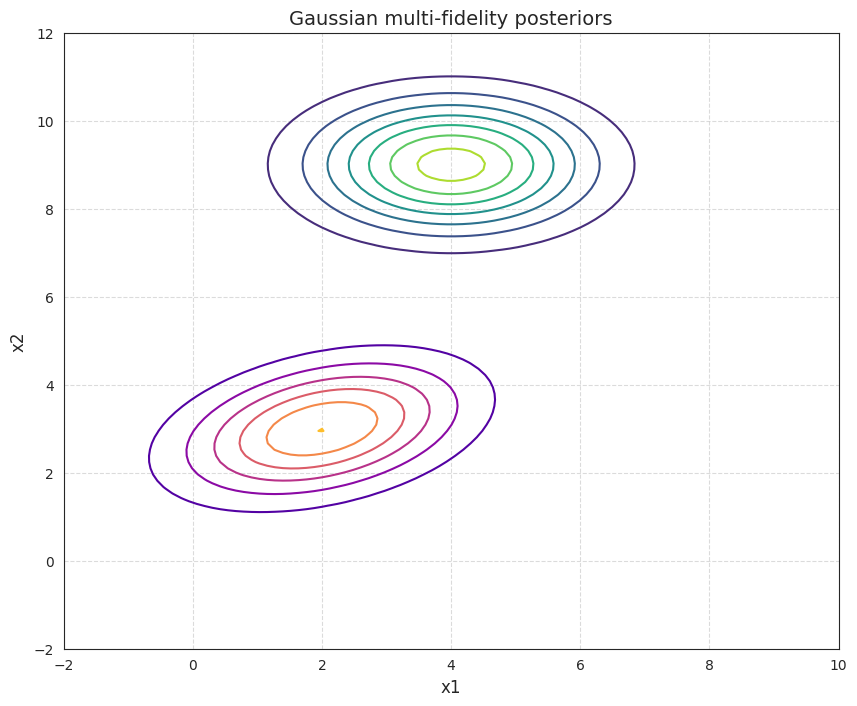

In [3]:
# Lets plot to see how our banana model looks like
# Define the grid
x1 = np.linspace(-2, 10, 100)
x2 = np.linspace(-2, 12, 100)
X1, X2 = np.meshgrid(x1, x2)

# Define the inputs
x = np.vstack([X1.ravel(), X2.ravel()])

# Compute the log posterior
output_coarse = gaussian_model_coarse(x)
output_fine = gaussian_model_fine(x)
# output = Gaussian_model(x)

# Reshape the output
log_posterior_coarse = output_coarse['log_posterior'].reshape(X1.shape)
log_posterior_coarse = np.exp(log_posterior_coarse)  # Convert log posterior to posterior

log_posterior_fine = output_fine['log_posterior'].reshape(X1.shape)
log_posterior_fine = np.exp(log_posterior_fine)  # Convert log posterior to posterior

# Plot the log posterior using seaborn
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.set_style("white")

# Create contour plot with fewer levels and no fill
sns.kdeplot(x=None, y=None, fill=False, levels=7, cmap="viridis", linewidths=1.5)

# Since kdeplot expects data to fit a distribution, we need to use plt.contour directly
plt.contour(X1, X2, log_posterior_coarse, levels=7, cmap="viridis", linewidths=1.5)
plt.contour(X1, X2, log_posterior_fine, levels=7, cmap="plasma", linewidths=1.5)

# plt.colorbar(label='Log Posterior')
plt.title('Gaussian multi-fidelity posteriors', fontsize=14)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [9]:
# This is just a simple example of how to use the samosa package
from samosa.kernels.synce import SYNCEKernel
from samosa.proposals.gaussianproposal import GaussianRandomWalk
from samosa.proposals.adapters import HaarioAdapter, GlobalAdapter
from samosa.core.proposal import AdaptiveProposal

from samosa.samplers.coupled_chain import coupledMCMCsampler

from samosa.utils.post_processing import get_position_from_states

# Define the proposal
proposal = GaussianRandomWalk(mu=np.zeros((2,1)), sigma=np.eye(2))
# adapter = HaarioAdapter(scale=2.38**2/2, adapt_start=1000, adapt_end=10000)
adapter = GlobalAdapter(ar=0.44, adapt_start=100, adapt_end=20000)
adaptive_proposal = AdaptiveProposal(proposal, adapter)

model_coarse = gaussian_model_coarse
model_fine = gaussian_model_fine

# Define the kernel
kernel = SYNCEKernel(model_coarse, model_fine)

sampler = coupledMCMCsampler(model_coarse, model_fine, kernel, adaptive_proposal, adaptive_proposal, initial_position_coarse=np.zeros((2, 1)), initial_position_fine=np.zeros((2, 1)), n_iterations=50000) 
ar1, ar2 = sampler.run('coupledGaussian')

print("Acceptance rate:", ar1)
print("Acceptance rate:", ar2)

# Load samples from the output directory
samples_coarse, samples_fine = sampler.load_samples('coupledGaussian')

# Get the positions of the samples
burnin = 0.4
positions_coarse = get_position_from_states(samples_coarse, burnin)
positions_fine = get_position_from_states(samples_fine, burnin)
print("Positions shape:", positions_coarse.shape)

print("Mean of the coarse samples:", np.mean(positions_coarse, axis=1))
print("Standard deviation of the samples:", np.std(positions_fine, axis=1))

print("Mean of the fine samples:", np.mean(positions_fine, axis=1))
print("Standard deviation of the samples:", np.std(positions_fine, axis=1))

# Compute the correlation between positions_fine and positions_coarse
correlations = []
for i in range(positions_fine.shape[0]):
    correlation_matrix = np.corrcoef(positions_fine[i], positions_coarse[i])
    correlation = correlation_matrix[0, 1]
    correlations.append(correlation)
    print(f"Correlation in dimension {i + 1}: {correlation}")

# Plot the scatter plot of the samples
# from samosa.utils.post_processing import scatter_matrix, plot_trace, plot_lag
# fig, _, _ = scatter_matrix([positions_coarse, positions_fine])
# plt.show()
# plt.close(fig)

# Plot the trace of the samples
# fig, _ = plot_trace(positions_coarse)
# plt.show()
# plt.close(fig)
# fig, _ = plot_trace(positions_fine)
# plt.show()
# plt.close(fig)

# Plot the lag of the samples
# fig, _ = plot_lag(positions_coarse)
# plt.show()
# plt.close(fig)
# fig, _ = plot_lag(positions_fine)
# plt.show()
# plt.close(fig)

Acceptance rate: 0.43248
Acceptance rate: 0.42538
Positions shape: (2, 30000)
Mean of the coarse samples: [4.00621991 8.99619866]
Standard deviation of the samples: [1.41351842 0.98010683]
Mean of the fine samples: [2.01281321 2.99856166]
Standard deviation of the samples: [1.41351842 0.98010683]
Correlation in dimension 1: 0.6594279910085186
Correlation in dimension 2: 0.6470785546084711


In [ ]:
# This is just a simple example of how to use the samosa package
from samosa.kernels.synce import SYNCEKernel
from samosa.proposals.gaussianproposal import GaussianRandomWalk
from samosa.proposals.adapters import HaarioAdapter, GlobalAdapter
from samosa.core.proposal import AdaptiveProposal

from samosa.samplers.coupled_chain import coupledMCMCsampler

from samosa.utils.post_processing import get_position_from_states

# Define the proposal
proposal = GaussianRandomWalk(mu=np.zeros((2,1)), sigma=np.eye(2))
# adapter = HaarioAdapter(scale=2.38**2/2, adapt_start=1000, adapt_end=10000)
adapter = GlobalAdapter(ar=0.44, adapt_start=100, adapt_end=20000)
adaptive_proposal = AdaptiveProposal(proposal, adapter)

model_coarse = gaussian_model_coarse
model_fine = gaussian_model_fine

# Define the kernel
kernel = SYNCEKernel(model_coarse, model_fine)

sampler = coupledMCMCsampler(model_coarse, model_fine, kernel, adaptive_proposal, adaptive_proposal, initial_position_coarse=np.zeros((2, 1)), initial_position_fine=np.zeros((2, 1)), n_iterations=50000) 
ar1, ar2 = sampler.run('coupledGaussian')

print("Acceptance rate:", ar1)
print("Acceptance rate:", ar2)

# Load samples from the output directory
samples_coarse, samples_fine = sampler.load_samples('coupledGaussian')

# Get the positions of the samples
burnin = 0.4
positions_coarse = get_position_from_states(samples_coarse, burnin)
positions_fine = get_position_from_states(samples_fine, burnin)
print("Positions shape:", positions_coarse.shape)

print("Mean of the coarse samples:", np.mean(positions_coarse, axis=1))
print("Standard deviation of the samples:", np.std(positions_fine, axis=1))

print("Mean of the fine samples:", np.mean(positions_fine, axis=1))
print("Standard deviation of the samples:", np.std(positions_fine, axis=1))

# Compute the correlation between positions_fine and positions_coarse
correlations = []
for i in range(positions_fine.shape[0]):
    correlation_matrix = np.corrcoef(positions_fine[i], positions_coarse[i])
    correlation = correlation_matrix[0, 1]
    correlations.append(correlation)
    print(f"Correlation in dimension {i + 1}: {correlation}")

# Plot the scatter plot of the samples
# from samosa.utils.post_processing import scatter_matrix, plot_trace, plot_lag
# fig, _, _ = scatter_matrix([positions_coarse, positions_fine])
# plt.show()
# plt.close(fig)

# Plot the trace of the samples
# fig, _ = plot_trace(positions_coarse)
# plt.show()
# plt.close(fig)
# fig, _ = plot_trace(positions_fine)
# plt.show()
# plt.close(fig)

# Plot the lag of the samples
# fig, _ = plot_lag(positions_coarse)
# plt.show()
# plt.close(fig)
# fig, _ = plot_lag(positions_fine)
# plt.show()
# plt.close(fig)